In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import os
from sklearn.tree import DecisionTreeClassifier

def is_categorical(series, threshold=10):
    return series.nunique() <= threshold or series.dtype == 'object'

def get_optimal_bins(series, method='fd'):
    series = series.dropna()
    n = len(series)
    if n == 0:
        return 3

    if method == 'sturges':
        return int(np.ceil(np.log2(n) + 1))
    elif method == 'fd':
        iqr = series.quantile(0.75) - series.quantile(0.25)
        bin_width = 2 * iqr / (n ** (1 / 3))
        if bin_width == 0:
            return 3
        return int(np.ceil((series.max() - series.min()) / bin_width))
    else:
        return 3

def decision_tree_binning(series, target, max_leaf_nodes=6):
    df_tmp = pd.DataFrame({'x': series, 'y': target}).dropna()
    clf = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, min_samples_leaf=0.05, random_state=42)
    clf.fit(df_tmp[['x']], df_tmp['y'])
    thresholds = np.sort(clf.tree_.threshold[clf.tree_.threshold > -2])
    bins = [-np.inf] + thresholds.tolist() + [np.inf]
    return pd.cut(series, bins=bins)

def plot_all_features(
    df,
    features,
    target_col,
    bin_method='fd',  # 'fd', 'sturges', 'tree'
    max_cols=2,
    figsize=(14, 5),
    normalize_target=False,
    bar_color='skyblue',
    line_color='red',
    marker='o',
    save_path=None
):
    num_features = len(features)
    num_rows = math.ceil(num_features / max_cols)

    fig, axes = plt.subplots(num_rows, max_cols, figsize=(figsize[0], figsize[1] * num_rows))
    if num_features == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for idx, feature in enumerate(features):
        ax1 = axes[idx]
        ax2 = ax1.twinx()

        df_valid = df[[feature, target_col]].dropna()

        try:
            if normalize_target:
                min_val = df_valid[target_col].min()
                max_val = df_valid[target_col].max()
                if max_val > min_val:
                    df_valid[target_col] = (df_valid[target_col] - min_val) / (max_val - min_val)

            if is_categorical(df_valid[feature]):
                grouped = df_valid.groupby(feature).agg(
                    user_count=(feature, 'count'),
                    target_rate=(target_col, 'mean')
                ).reset_index()
                grouped['user_ratio'] = grouped['user_count'] / grouped['user_count'].sum()
                x_vals = grouped[feature].astype(str)

            else:
                if bin_method == 'tree':
                    df_valid['bin'] = decision_tree_binning(df_valid[feature], df_valid[target_col])
                else:
                    n_bins = get_optimal_bins(df_valid[feature], method=bin_method)
                    bin_col = pd.qcut(df_valid[feature], q=n_bins, duplicates='drop')

                    intervals = bin_col.cat.categories
                    left_inf = -np.inf if df_valid[feature].min() < intervals[0].left else intervals[0].left
                    right_inf = np.inf if df_valid[feature].max() > intervals[-1].right else intervals[-1].right

                    new_intervals = pd.IntervalIndex.from_tuples(
                        [(left_inf, intervals[0].right)] +
                        [(i.left, i.right) for i in intervals[1:-1]] +
                        [(intervals[-1].left, right_inf)]
                    )

                    df_valid['bin'] = pd.Categorical(bin_col, categories=new_intervals, ordered=True)

                # group by bin
                grouped = df_valid.groupby('bin').agg(
                    user_count=(feature, 'count'),
                    target_rate=(target_col, 'mean')
                ).reset_index()

                # 빈 구간 제거
                grouped = grouped[grouped['user_count'] > 0]

                grouped['user_ratio'] = grouped['user_count'] / grouped['user_count'].sum()
                x_vals = grouped['bin'].astype(str)

            ax1.bar(x_vals, grouped['user_ratio'], color=bar_color)
            ax1.set_ylabel('user ratio')

            ax2.plot(x_vals, grouped['target_rate'], color=line_color, marker=marker)
            ax2.set_ylabel('target_rate', color=line_color)

            ax1.set_title(f"target_rate by {feature}")
            ax1.tick_params(axis='x', rotation=45)

        except Exception as e:
            ax1.set_title(f"{feature} - 오류 발생")
            print(f"[ERROR] '{feature}' 처리 중 오류: {e}")

    for i in range(len(features), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()

    if save_path:
        dirname = os.path.dirname(save_path)
        if dirname and not os.path.exists(dirname):
            os.makedirs(dirname)
        fig.savefig(save_path, dpi=300)
        print(f"✅ 그래프 저장 완료: {save_path}")

    plt.show()


# 샘플 데이터
df = pd.DataFrame({
    'price': np.random.uniform(0, 300, 500),
    'period': np.random.randint(0, 1000, 500),
    'product_type': np.random.choice(['A', 'B', 'C'], 500),
    'channel': np.random.choice(['online', 'offline'], 500),
    'age': np.random.randint(20, 70, 500),
    'target': np.random.choice([0, 1], 500, p=[0.8, 0.2])
})

# 실행 예시: 정보이득 기반 binning 적용
plot_all_features(
    df,
    features=['price', 'period', 'product_type', 'channel', 'age'],
    target_col='target',
    bin_method='tree',  # ← 여기만 'tree'로 설정하면 정보이득 기반 적용됨
    normalize_target=True,
    bar_color='skyblue',
    line_color='darkorange',
    marker='s',
    save_path='output/tree_binned_feature_visuals.png'
)


In [ ]:
import pandas as pd
import numpy as np

def calculate_iv(df, feature, target, bin_strategy='fd'):
    """
    Calculate IV using an automatic binning strategy: 'sturges', 'fd', or an int.
    """
    df = df[[feature, target]].copy()

    # Determine bin count
    if pd.api.types.is_numeric_dtype(df[feature]):
        n = df.shape[0]
        if bin_strategy == 'sturges':
            bins = int(np.ceil(np.log2(n) + 1))
        elif bin_strategy == 'fd':
            q75, q25 = np.percentile(df[feature].dropna(), [75, 25])
            iqr = q75 - q25
            bin_width = 2 * iqr / (n ** (1/3))
            if bin_width == 0:
                bins = 3  # fallback
            else:
                bins = int(np.ceil((df[feature].max() - df[feature].min()) / bin_width))
                bins = max(bins, 2)
        elif isinstance(bin_strategy, int):
            bins = bin_strategy
        else:
            raise ValueError("bin_strategy must be 'sturges', 'fd', or an integer")

        # Create bins
        try:
            df['bin'] = pd.qcut(df[feature], q=bins, duplicates='drop')
            if len(df['bin'].cat.categories) <= 1:
                df['bin'] = pd.cut(df[feature], bins=bins, duplicates='drop')
        except:
            df['bin'] = pd.cut(df[feature], bins=bins, duplicates='drop')

    else:
        df['bin'] = df[feature]

    # IV 계산
    grouped = df.groupby('bin', observed=True)[target].agg(['count', 'sum'])
    grouped['non_event'] = grouped['count'] - grouped['sum']
    grouped['event_rate'] = grouped['sum'] / grouped['sum'].sum()
    grouped['non_event_rate'] = grouped['non_event'] / grouped['non_event'].sum()

    grouped['event_rate'].replace(0, 1e-8, inplace=True)
    grouped['non_event_rate'].replace(0, 1e-8, inplace=True)

    grouped['woe'] = np.log(grouped['event_rate'] / grouped['non_event_rate'])
    grouped['iv'] = (grouped['event_rate'] - grouped['non_event_rate']) * grouped['woe']
    iv = grouped['iv'].sum()

    grouped = grouped.reset_index().rename(columns={'bin': 'range'})
    df.drop(columns=['bin'], inplace=True)

    return iv, grouped[['range', 'event_rate', 'non_event_rate', 'woe', 'iv']]


In [ ]:
# 최종

import pandas as pd
import numpy as np

def calculate_iv(df, feature, target, bin_strategy='fd'):
    """
    Calculate Information Value (IV) and Weight of Evidence (WOE) for a given feature.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing the feature and target.
        feature (str): Feature column name.
        target (str): Target column name (binary: 0/1).
        bin_strategy (str or int): 'fd', 'sturges', or an integer for number of bins.

    Returns:
        float: IV value for the feature.
        pd.DataFrame: Summary with WOE and IV per bin/category.
    """
    df = df[[feature, target]].copy()

    if pd.api.types.is_numeric_dtype(df[feature]):
        n = df.shape[0]

        # Determine number of bins
        if bin_strategy == 'sturges':
            bins = int(np.ceil(np.log2(n) + 1))
        elif bin_strategy == 'fd':
            q75, q25 = np.percentile(df[feature].dropna(), [75, 25])
            iqr = q75 - q25
            bin_width = 2 * iqr / (n ** (1/3))
            if bin_width == 0:
                bins = 3
            else:
                bins = int(np.ceil((df[feature].max() - df[feature].min()) / bin_width))
                bins = max(bins, 2)
        elif isinstance(bin_strategy, int):
            bins = bin_strategy
        else:
            raise ValueError("Invalid bin_strategy. Choose 'fd', 'sturges', or an integer.")

        # Create bin edges and apply -inf/inf
        try:
            quantiles = df[feature].quantile(np.linspace(0, 1, bins + 1)).unique()
            cut_points = sorted(set(quantiles))
            cut_points[0] = -np.inf
            cut_points[-1] = np.inf
            df['bin'] = pd.cut(df[feature], bins=cut_points, duplicates='drop')
        except Exception:
            df['bin'] = pd.cut(df[feature], bins=bins)
    else:
        # df[feature] = df[feature].astype(str).fillna("MISSING")
        df['bin'] = df[feature]

    # WOE & IV calculations
    grouped = df.groupby('bin', observed=True)[target].agg(['count', 'sum'])
    grouped['non_event'] = grouped['count'] - grouped['sum']
    grouped['event_rate'] = grouped['sum'] / grouped['sum'].sum()
    grouped['non_event_rate'] = grouped['non_event'] / grouped['non_event'].sum()

    # Prevent division by zero
    grouped['event_rate'].replace(0, 1e-8, inplace=True)
    grouped['non_event_rate'].replace(0, 1e-8, inplace=True)

    grouped['woe'] = np.log(grouped['event_rate'] / grouped['non_event_rate'])
    grouped['iv'] = (grouped['event_rate'] - grouped['non_event_rate']) * grouped['woe']

    iv = grouped['iv'].sum()
    grouped = grouped.reset_index().rename(columns={'bin': 'range'})

    return iv, grouped[['range', 'event_rate', 'non_event_rate', 'woe', 'iv']]


In [ ]:
import pandas as pd
import pickle
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import roc_auc_score, average_precision_score

# -----------------------------
# 1. 데이터 로딩
# -----------------------------
with open("df_total_modified_0.pkl", "rb") as f:
    df_part0 = pickle.load(f)

with open("df_total_modified_1.pkl", "rb") as f:
    df_part1 = pickle.load(f)

with open("df_total_modified_2.pkl", "rb") as f:
    df_part2 = pickle.load(f)

df = pd.concat([df_part0, df_part1, df_part2], ignore_index=True)
del df_part0, df_part1, df_part2

# -----------------------------
# 2. 피처/타겟 정의
# -----------------------------
with open("votes_df.pkl", "rb") as f:
    votes_df = pickle.load(f)

voted_features = list(votes_df.columns[votes_df.sum() > 1.5])
categorical_cols = ["age","gender"]
non_feature_cols = ["account_id", "label", "create_at", "base_date"]

# -----------------------------
# 3. 결측치 처리
# -----------------------------
X = df[voted_features].copy()
y = df["label"].astype(int)

X = X.fillna(-999)

# 범주형 변수 타입 지정
for col in categorical_cols:
    if col in X.columns:
        X[col] = X[col].astype("category")

# -----------------------------
# 4. 학습/검증 데이터 분할
# -----------------------------
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# -----------------------------
# 5. 클래스 가중치 계산
# -----------------------------
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
sample_weights = y_train.map(class_weight_dict)

# -----------------------------
# 6. 모델 학습
# -----------------------------
lgbm_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    objective="binary",
    random_state=42
)

lgbm_model.fit(
    X_train,
    y_train,
    sample_weight=sample_weights,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=30,
    verbose=50,
    categorical_feature=[col for col in categorical_cols if col in voted_features]
)

# -----------------------------
# 7. 평가 지표
# -----------------------------
y_pred = lgbm_model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred)
pr_auc = average_precision_score(y_val, y_pred)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC:  {pr_auc:.4f}")

# -----------------------------
# 8. Feature Importance
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance_df = pd.DataFrame({
    "feature": voted_features,
    "importance": lgbm_model.feature_importances_
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 30))
sns.barplot(data=feature_importance_df.head(50), x="importance", y="feature")
plt.title("Top 50 Feature Importances")
plt.tight_layout()
plt.show()

with open("trained_lgbm_model.pkl", "wb") as f:
    pickle.dump(lgbm_model, f)

feature_importance_df.to_csv("lgbm_feature_importances.csv", index=False)


In [ ]:
# Optuna를 활용한 LGBM 튜닝 코드

import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

def objective(trial):
    params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
        "random_state": 42,
        "n_estimators": 100
    }

    model = LGBMClassifier(**params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="auc",
        early_stopping_rounds=20,
        verbose=0
    )

    y_pred = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred)
    return auc_score

# 데이터 준비
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Optuna 실행
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적 파라미터 출력
print("Best trial:")
print(study.best_trial.params)


# 2. Time-aware Split (월별 또는 기준일 기반)
# 예: base_date 컬럼 기준으로 월별 나누기
df["base_month"] = pd.to_datetime(df["base_date"]).dt.to_period("M")
train_df = df[df["base_month"] <= "2025-05"]
val_df = df[df["base_month"] == "2025-06"]

X_train = train_df[voted_features].fillna(-999)
X_val = val_df[voted_features].fillna(-999)
y_train = train_df["label"].astype(int)
y_val = val_df["label"].astype(int)

# 3. 모델 앙상블 확장 예
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

ensemble_model = VotingClassifier(
    estimators=[
        ("lgbm", LGBMClassifier(**study.best_trial.params)),
        ("xgb", XGBClassifier(eval_metric="auc"))
    ],
    voting="soft"
)

ensemble_model.fit(X_train, y_train)

# 4. 모델 저장 & 추론 파이프라인
import joblib

# 저장
joblib.dump(lgbm_model, "lgbm_model.pkl")

# 불러오기 및 추론
loaded_model = joblib.load("lgbm_model.pkl")
y_pred = loaded_model.predict_proba(X_val)[:, 1]


# AUROC (Area Under ROC Curve)
## AUROC는 모델의 분류 성능을 전반적으로 평가하는 지표입니다. 값이 1에 가까울수록 좋고, 0.5는 랜덤 추측 수준입니다.

from sklearn.metrics import roc_auc_score

def compute_auroc(y_true, y_score):
    """
    y_true: 실제 라벨 (0 또는 1)
    y_score: 모델의 예측 확률 (0~1 사이)
    """
    return roc_auc_score(y_true, y_score)

# K-S 통계량 (Kolmogorov-Smirnov Statistic)

## K-S 통계량은 양성(1) 클래스와 음성(0) 클래스의 예측확률 분포 간 최대 거리를 의미합니다. 보통 0.2 이상이면 좋은 분류력으로 간주합니다.
import numpy as np
import pandas as pd

def compute_ks_statistic(y_true, y_score):
    """
    y_true: 실제 라벨 (0 또는 1)
    y_score: 모델 예측 확률
    """
    df = pd.DataFrame({"y_true": y_true, "y_score": y_score})
    df = df.sort_values("y_score", ascending=False)

    df["cum_event_rate"] = (df["y_true"] == 1).cumsum() / (df["y_true"] == 1).sum()
    df["cum_non_event_rate"] = (df["y_true"] == 0).cumsum() / (df["y_true"] == 0).sum()

    df["ks"] = np.abs(df["cum_event_rate"] - df["cum_non_event_rate"])

    ks_stat = df["ks"].max()
    return ks_stat


# 예측 확률
y_score = model.predict_proba(X_val)[:, 1]
# 실제 값
y_true = y_val

# AUROC
auroc = compute_auroc(y_true, y_score)
print(f"AUROC: {auroc:.4f}")

# KS 통계량
ks = compute_ks_statistic(y_true, y_score)
print(f"K-S Statistic: {ks:.4f}")

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def plot_ks_curve(y_true, y_score):
    df = pd.DataFrame({"y_true": y_true, "y_score": y_score})
    df = df.sort_values("y_score", ascending=False)
    df["event"] = (df["y_true"] == 1).astype(int)
    df["non_event"] = (df["y_true"] == 0).astype(int)

    df["cum_event_rate"] = df["event"].cumsum() / df["event"].sum()
    df["cum_non_event_rate"] = df["non_event"].cumsum() / df["non_event"].sum()

    plt.figure(figsize=(8, 6))
    plt.plot(df["cum_event_rate"], label="Cumulative Event Rate")
    plt.plot(df["cum_non_event_rate"], label="Cumulative Non-Event Rate")
    plt.title("K-S Curve")
    plt.xlabel("Sample Index")
    plt.ylabel("Cumulative Rate")
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
#
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from scipy.stats import ks_2samp
import pickle

# 데이터 로딩
with open('df_total_modified_0.pkl', 'rb') as f:
    df_total_0 = pickle.load(f)
with open('df_total_modified_1.pkl', 'rb') as f:
    df_total_1 = pickle.load(f)
with open('df_total_modified_2.pkl', 'rb') as f:
    df_total_2 = pickle.load(f)

df = pd.concat([df_total_0, df_total_1, df_total_2])
df['base_date'] = pd.to_datetime(df['base_date'])

# 전처리 설정
non_feature_cols = ['account_id', 'label', 'create_at', 'base_date']
candidate_cols = [col for col in df.columns if col not in non_feature_cols]
categorical_cols = df[candidate_cols].select_dtypes(include=['category']).columns.tolist()

# 월별 그룹
df['year_month'] = df['base_date'].dt.to_period('M')
months = sorted(df['year_month'].astype(str).unique())

# 결과 저장
results = []

# 5-Step OOT 평가
for i in range(len(months) - 1 - 4):
    train_month = months[i]
    test_month = months[i + 1]

    train_df = df[df['year_month'] == train_month]
    test_df = df[df['year_month'] == test_month]

    X_train = train_df[candidate_cols]
    y_train = train_df['label']
    X_test = test_df[candidate_cols]
    y_test = test_df['label']

    model = LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train, y_train, categorical_feature=categorical_cols)

    y_pred_prob = model.predict_proba(X_test)[:, 1]

    auroc = roc_auc_score(y_test, y_pred_prob)
    ks = ks_2samp(y_pred_prob[y_test == 1], y_pred_prob[y_test == 0]).statistic

    results.append({
        "train_month": train_month,
        "test_month": test_month,
        "AUROC": round(auroc, 4),
        "KS": round(ks, 4),
        "n_test": len(y_test),
        "n_event": int(y_test.sum()),
        "n_non_event": int((y_test == 0).sum())
    })

results_df = pd.DataFrame(results)
print(results_df)


In [ ]:
# Optuna + LGBM 튜닝 전체 워크플로우 코드
import optuna
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp
from lightgbm import LGBMClassifier
import pickle

# 1. 데이터 불러오기
with open('df_total_modified_0.pkl', 'rb') as f:
    df_total_0 = pickle.load(f)
with open('df_total_modified_1.pkl', 'rb') as f:
    df_total_1 = pickle.load(f)
with open('df_total_modified_2.pkl', 'rb') as f:
    df_total_2 = pickle.load(f)

df = pd.concat([df_total_0, df_total_1, df_total_2])
df['base_date'] = pd.to_datetime(df['base_date'])
df['year_month'] = df['base_date'].dt.to_period('M')

non_feature_cols = ['account_id', 'label', 'create_at', 'base_date']
candidate_cols = [col for col in df.columns if col not in non_feature_cols]
categorical_cols = df[candidate_cols].select_dtypes(include='category').columns.tolist()

# 2. Optuna 목적 함수 정의
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 15, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'class_weight': 'balanced',
        'random_state': 42
    }

    # 학습: 첫 달, 평가: 그 다음 달
    train_month, test_month = '2025-05', '2025-06'
    train_df = df[df['year_month'] == train_month]
    test_df = df[df['year_month'] == test_month]

    X_train, y_train = train_df[candidate_cols], train_df['label']
    X_test, y_test = test_df[candidate_cols], test_df['label']

    model = LGBMClassifier(**params)
    model.fit(X_train, y_train, categorical_feature=categorical_cols)

    y_pred = model.predict_proba(X_test)[:, 1]
    auroc = roc_auc_score(y_test, y_pred)
    return auroc  # Optuna는 AUROC를 maximize

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=1200)  # 최대 30회, 20분 제한

print("Best trial:")
print(study.best_trial.params)

best_params = study.best_trial.params
best_params.update({
    "class_weight": "balanced",
    "random_state": 42
})

results = []
months = sorted(df['year_month'].astype(str).unique())

for i in range(len(months) - 5):
    train_month = months[i]
    test_month = months[i + 1]

    train_df = df[df['year_month'] == train_month]
    test_df = df[df['year_month'] == test_month]

    X_train, y_train = train_df[candidate_cols], train_df['label']
    X_test, y_test = test_df[candidate_cols], test_df['label']

    model = LGBMClassifier(**best_params)
    model.fit(X_train, y_train, categorical_feature=categorical_cols)

    y_pred = model.predict_proba(X_test)[:, 1]

    auroc = roc_auc_score(y_test, y_pred)
    ks = ks_2samp(y_pred[y_test == 1], y_pred[y_test == 0]).statistic

    results.append({
        "train_month": train_month,
        "test_month": test_month,
        "AUROC": round(auroc, 4),
        "KS": round(ks, 4),
        "n_test": len(y_test),
        "n_event": int(y_test.sum()),
        "n_non_event": int((y_test == 0).sum())
    })

results_df = pd.DataFrame(results)
print(results_df)


In [ ]:
import pandas as pd
import numpy as np
import optuna
import pickle
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp

# --------------------------
# 1. 데이터 로딩
# --------------------------
with open('df_total_modified_0.pkl', 'rb') as f:
    df_total_0 = pickle.load(f)
with open('df_total_modified_1.pkl', 'rb') as f:
    df_total_1 = pickle.load(f)
with open('df_total_modified_2.pkl', 'rb') as f:
    df_total_2 = pickle.load(f)

df = pd.concat([df_total_0, df_total_1, df_total_2])
df['base_date'] = pd.to_datetime(df['base_date'])
df['year_month'] = df['base_date'].dt.to_period('M')

non_feature_cols = ['account_id', 'label', 'create_at', 'base_date']
candidate_cols = [col for col in df.columns if col not in non_feature_cols]
categorical_cols = df[candidate_cols].select_dtypes(include='category').columns.tolist()

# --------------------------
# 2. Optuna 목적 함수 정의
# --------------------------
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 15, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'class_weight': 'balanced',
        'random_state': 42
    }

    train_df = df[df['year_month'] == '2025-03']
    test_df = df[df['year_month'] == '2025-04']

    X_train, y_train = train_df[candidate_cols], train_df['label']
    X_test, y_test = test_df[candidate_cols], test_df['label']

    model = LGBMClassifier(**params)
    model.fit(X_train, y_train, categorical_feature=categorical_cols)

    y_pred = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred)

# --------------------------
# 3. Optuna 튜닝 실행
# --------------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

best_params = study.best_trial.params
best_params.update({'class_weight': 'balanced', 'random_state': 42})
print("Best params:", best_params)

# --------------------------
# 4. OOT 평가 (2회)
# --------------------------
results = []
for train_month, test_month in [('2025-03', '2025-04'), ('2025-04', '2025-05')]:
    train_df = df[df['year_month'] == train_month]
    test_df = df[df['year_month'] == test_month]

    X_train, y_train = train_df[candidate_cols], train_df['label']
    X_test, y_test = test_df[candidate_cols], test_df['label']

    model = LGBMClassifier(**best_params)
    model.fit(X_train, y_train, categorical_feature=categorical_cols)

    y_pred = model.predict_proba(X_test)[:, 1]
    auroc = roc_auc_score(y_test, y_pred)
    ks = ks_2samp(y_pred[y_test == 1], y_pred[y_test == 0]).statistic

    results.append({
        'train_month': train_month,
        'test_month': test_month,
        'AUROC': round(auroc, 4),
        'KS': round(ks, 4),
        'n_test': len(y_test),
        'n_event': int(y_test.sum()),
        'n_non_event': int((y_test == 0).sum())
    })

results_df = pd.DataFrame(results)
print(results_df)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import pandas as pd

def plot_roc_curve(y_true, y_score, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Model')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

def plot_ks_curve(y_true, y_score, title="KS Curve"):
    df_ks = pd.DataFrame({'y_true': y_true, 'y_score': y_score})
    df_ks = df_ks.sort_values(by='y_score', ascending=False).reset_index(drop=True)

    df_ks['cum_event'] = (df_ks['y_true'] == 1).cumsum() / (df_ks['y_true'] == 1).sum()
    df_ks['cum_non_event'] = (df_ks['y_true'] == 0).cumsum() / (df_ks['y_true'] == 0).sum()
    df_ks['ks'] = np.abs(df_ks['cum_event'] - df_ks['cum_non_event'])

    ks_max = df_ks['ks'].max()
    ks_max_idx = df_ks['ks'].idxmax()

    plt.figure(figsize=(6, 6))
    plt.plot(df_ks['cum_event'], label='Cumulative Event Rate (TPR)')
    plt.plot(df_ks['cum_non_event'], label='Cumulative Non-Event Rate (FPR)')
    plt.axvline(ks_max_idx / len(df_ks), color='r', linestyle='--', label=f'KS = {ks_max:.4f}')
    plt.title(title)
    plt.xlabel('Proportion of Population')
    plt.ylabel('Cumulative Rate')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# 예시: 두 번째 평가 (2025-04 → 2025-05)
plot_roc_curve(y_test, y_pred, title="ROC Curve: 2025-04 Train → 2025-05 Test")
plot_ks_curve(y_test, y_pred, title="KS Curve: 2025-04 Train → 2025-05 Test")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import os

def is_categorical(series, threshold=10):
    return series.nunique() <= threshold or series.dtype == 'object'

def get_optimal_bins(series, method='fd'):
    series = series.dropna()
    n = len(series)
    if n == 0:
        return 3

    if method == 'sturges':
        return int(np.ceil(np.log2(n) + 1))
    elif method == 'fd':
        iqr = series.quantile(0.75) - series.quantile(0.25)
        bin_width = 2 * iqr / (n ** (1 / 3))
        if bin_width == 0:
            return 3
        return int(np.ceil((series.max() - series.min()) / bin_width))
    else:
        return 3

def plot_all_features(
    df,
    features,
    target_col,
    bin_method='fd',
    max_cols=2,
    figsize=(14, 5),
    normalize_target=False,
    bar_color='skyblue',
    line_color='red',
    marker='o',
    save_path=None
):
    num_features = len(features)
    num_rows = math.ceil(num_features / max_cols)

    fig, axes = plt.subplots(num_rows, max_cols, figsize=(figsize[0], figsize[1] * num_rows))
    if num_features == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for idx, feature in enumerate(features):
        ax1 = axes[idx]
        ax2 = ax1.twinx()

        df_valid = df[[feature, target_col]].dropna()

        try:
            if normalize_target:
                min_val = df_valid[target_col].min()
                max_val = df_valid[target_col].max()
                if max_val > min_val:
                    df_valid[target_col] = (df_valid[target_col] - min_val) / (max_val - min_val)

            if is_categorical(df_valid[feature]):
                grouped = df_valid.groupby(feature).agg(
                    user_count=(feature, 'count'),
                    target_rate=(target_col, 'mean')
                ).reset_index()
                grouped['user_ratio'] = grouped['user_count'] / grouped['user_count'].sum()
                x_vals = grouped[feature].astype(str)

            else:
                n_bins = get_optimal_bins(df_valid[feature], method=bin_method)
                bin_col = pd.qcut(df_valid[feature], q=n_bins, duplicates='drop')

                intervals = bin_col.cat.categories
                left_inf = -np.inf if df_valid[feature].min() < intervals[0].left else intervals[0].left
                right_inf = np.inf if df_valid[feature].max() > intervals[-1].right else intervals[-1].right

                new_intervals = pd.IntervalIndex.from_tuples(
                    [(left_inf, intervals[0].right)] +
                    [(i.left, i.right) for i in intervals[1:-1]] +
                    [(intervals[-1].left, right_inf)]
                )

                df_valid['bin'] = pd.Categorical(bin_col, categories=new_intervals, ordered=True)

                grouped = df_valid.groupby('bin').agg(
                    user_count=(feature, 'count'),
                    target_rate=(target_col, 'mean')
                ).reset_index()

                # 빈 bin 제거
                grouped = grouped[grouped['user_count'] > 0]

                grouped['user_ratio'] = grouped['user_count'] / grouped['user_count'].sum()
                x_vals = grouped['bin'].astype(str)

            ax1.bar(x_vals, grouped['user_ratio'], color=bar_color)
            ax1.set_ylabel('user ratio')

            ax2.plot(x_vals, grouped['target_rate'], color=line_color, marker=marker)
            ax2.set_ylabel('target_rate', color=line_color)

            ax1.set_title(f"target_rate by {feature}")
            ax1.tick_params(axis='x', rotation=45)

        except Exception as e:
            ax1.set_title(f"{feature} - 오류 발생")
            print(f"[ERROR] '{feature}' 처리 중 오류: {e}")

    for i in range(len(features), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()

    if save_path:
        dirname = os.path.dirname(save_path)
        if dirname and not os.path.exists(dirname):
            os.makedirs(dirname)
        fig.savefig(save_path, dpi=300)
        print(f"✅ 그래프 저장 완료: {save_path}")

    plt.show()


# 예시 데이터
df = pd.DataFrame({
    'price': np.random.uniform(0, 300, 500),
    'period': np.random.randint(0, 1000, 500),
    'product_type': np.random.choice(['A', 'B', 'C'], 500),
    'channel': np.random.choice(['online', 'offline'], 500),
    'age': np.random.randint(20, 70, 500),
    'target': np.random.choice([0, 1], 500, p=[0.8, 0.2])
})

# 실행
plot_all_features(
    df,
    features=['price', 'period', 'product_type', 'channel', 'age'],
    target_col='target',
    bin_method='fd',
    normalize_target=True,
    bar_color='skyblue',
    line_color='darkorange',
    marker='s',
    save_path='output/feature_visuals.png'
)


/tmp/ipython-input-5-3227291280.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_valid.groupby('bin').agg(
/tmp/ipython-input-5-3227291280.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_valid.groupby('bin').agg(
/tmp/ipython-input-5-3227291280.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_valid.groupby('bin').agg(


✅ 그래프 저장 완료: output/feature_visuals.png


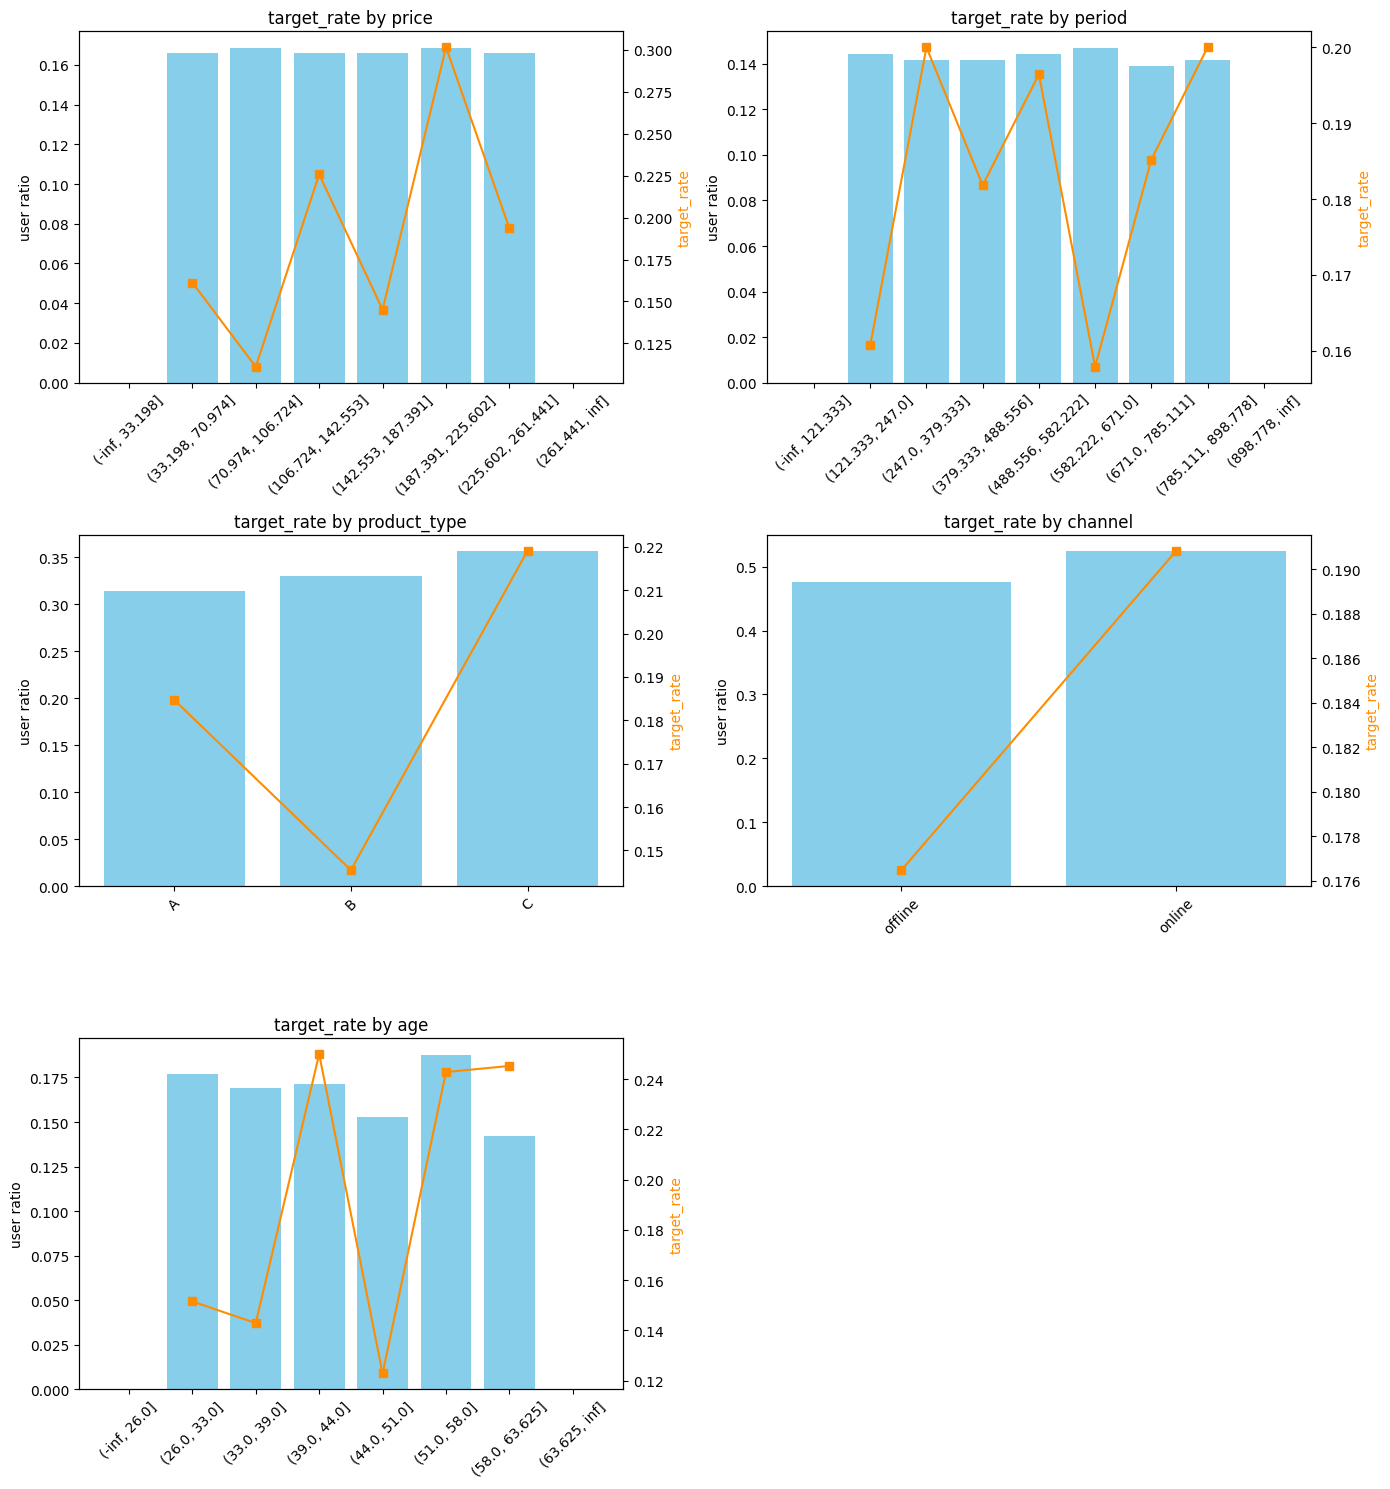

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import os

# 범주형 판단 함수
def is_categorical(series, threshold=10):
    return series.nunique() <= threshold or series.dtype == 'object'

# 최적 bin 수 계산 함수
def get_optimal_bins(series, method='fd'):
    series = series.dropna()
    n = len(series)
    if n == 0:
        return 3

    if method == 'sturges':
        return int(np.ceil(np.log2(n) + 1))
    elif method == 'fd':
        iqr = series.quantile(0.75) - series.quantile(0.25)
        bin_width = 2 * iqr / (n ** (1 / 3))
        if bin_width == 0:
            return 3
        return int(np.ceil((series.max() - series.min()) / bin_width))
    else:
        return 3

# 시각화 함수
def plot_all_features(
    df,
    features,
    target_col,
    bin_method='fd',
    max_cols=2,
    figsize=(14, 5),
    normalize_target=False,
    bar_color='skyblue',
    line_color='red',
    marker='o',
    save_path=None
):
    num_features = len(features)
    num_rows = math.ceil(num_features / max_cols)

    fig, axes = plt.subplots(num_rows, max_cols, figsize=(figsize[0], figsize[1] * num_rows))
    if num_features == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for idx, feature in enumerate(features):
        ax1 = axes[idx]
        ax2 = ax1.twinx()

        df_valid = df[[feature, target_col]].dropna()

        try:
            if normalize_target:
                min_val = df_valid[target_col].min()
                max_val = df_valid[target_col].max()
                if max_val > min_val:
                    df_valid[target_col] = (df_valid[target_col] - min_val) / (max_val - min_val)

            if is_categorical(df_valid[feature]):
                grouped = df_valid.groupby(feature).agg(
                    user_count=(feature, 'count'),
                    target_rate=(target_col, 'mean')
                ).reset_index()
                grouped['user_ratio'] = grouped['user_count'] / grouped['user_count'].sum()
                x_vals = grouped[feature].astype(str)
            else:
                n_bins = get_optimal_bins(df_valid[feature], method=bin_method)
                bin_col = pd.qcut(df_valid[feature], q=n_bins, duplicates='drop')

                # -inf, inf 확장
                intervals = bin_col.cat.categories
                new_intervals = pd.IntervalIndex.from_tuples(
                    [(-np.inf, intervals[0].right)] +
                    [(i.left, i.right) for i in intervals[1:-1]] +
                    [(intervals[-1].left, np.inf)]
                )
                df_valid['bin'] = pd.Categorical(bin_col, categories=new_intervals, ordered=True)

                grouped = df_valid.groupby('bin').agg(
                    user_count=(feature, 'count'),
                    target_rate=(target_col, 'mean')
                ).reset_index()
                grouped['user_ratio'] = grouped['user_count'] / grouped['user_count'].sum()
                x_vals = grouped['bin'].astype(str)

            ax1.bar(x_vals, grouped['user_ratio'], color=bar_color)
            ax1.set_ylabel('user ratio')

            ax2.plot(x_vals, grouped['target_rate'], color=line_color, marker=marker)
            ax2.set_ylabel('target_rate', color=line_color)

            ax1.set_title(f"target_rate by {feature}")
            ax1.tick_params(axis='x', rotation=45)

        except Exception as e:
            ax1.set_title(f"{feature} - 오류 발생")
            print(f"[ERROR] '{feature}' 처리 중 오류: {e}")

    for i in range(len(features), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()

    if save_path:
        dirname = os.path.dirname(save_path)
        if dirname and not os.path.exists(dirname):
            os.makedirs(dirname)
        fig.savefig(save_path, dpi=300)
        print(f"✅ 그래프 저장 완료: {save_path}")

    plt.show()

# 샘플 데이터
df = pd.DataFrame({
    'price': np.random.uniform(0, 300, 500),
    'period': np.random.randint(0, 1000, 500),
    'product_type': np.random.choice(['A', 'B', 'C'], 500),
    'channel': np.random.choice(['online', 'offline'], 500),
    'age': np.random.randint(20, 70, 500),
    'target': np.random.choice([0, 1], 500, p=[0.8, 0.2])
})

# 시각화 호출
plot_all_features(
    df,
    features=['price', 'period', 'product_type', 'channel', 'age'],
    target_col='target',
    bin_method='fd',  # 자동 binning + -inf ~ inf 확장
    normalize_target=True,
    bar_color='skyblue',
    line_color='darkorange',
    marker='s',
    save_path='output/feature_visuals.png'
)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import os

# 범주형 판단
def is_categorical(series, threshold=10):
    return series.nunique() <= threshold or series.dtype == 'object'

# 최적 bin 수 계산 함수
def get_optimal_bins(series, method='fd'):
    series = series.dropna()
    n = len(series)

    if n == 0:
        return 3  # fallback for empty data

    if method == 'sturges':
        return int(np.ceil(np.log2(n) + 1))

    elif method == 'fd':  # Freedman-Diaconis Rule
        iqr = series.quantile(0.75) - series.quantile(0.25)
        bin_width = 2 * iqr / (n ** (1 / 3))
        if bin_width == 0:
            return 3  # fallback for constant data
        return int(np.ceil((series.max() - series.min()) / bin_width))

    else:
        return 3  # default fallback

# 메인 시각화 함수
def plot_all_features(
    df,
    features,
    target_col,
    bin_method='fd',
    max_cols=2,
    figsize=(14, 5),
    normalize_target=False,
    bar_color='skyblue',
    line_color='red',
    marker='o',
    save_path=None
):
    num_features = len(features)
    num_rows = math.ceil(num_features / max_cols)

    fig, axes = plt.subplots(num_rows, max_cols, figsize=(figsize[0], figsize[1] * num_rows))
    if num_features == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for idx, feature in enumerate(features):
        ax1 = axes[idx]
        ax2 = ax1.twinx()

        df_valid = df[[feature, target_col]].dropna()

        try:
            # target 정규화 옵션
            if normalize_target:
                min_val = df_valid[target_col].min()
                max_val = df_valid[target_col].max()
                if max_val > min_val:
                    df_valid[target_col] = (df_valid[target_col] - min_val) / (max_val - min_val)

            # 범주형 처리
            if is_categorical(df_valid[feature]):
                grouped = df_valid.groupby(feature).agg(
                    user_count=(feature, 'count'),
                    target_rate=(target_col, 'mean')
                ).reset_index()
                grouped['user_ratio'] = grouped['user_count'] / grouped['user_count'].sum()
                x_vals = grouped[feature].astype(str)

            # 연속형 처리
            else:
                optimal_bins = get_optimal_bins(df_valid[feature], method=bin_method)
                df_valid['bin'] = pd.qcut(df_valid[feature], q=optimal_bins, duplicates='drop')
                grouped = df_valid.groupby('bin').agg(
                    user_count=(feature, 'count'),
                    target_rate=(target_col, 'mean')
                ).reset_index()
                grouped['user_ratio'] = grouped['user_count'] / grouped['user_count'].sum()
                x_vals = grouped['bin'].astype(str)

            # Bar (user ratio)
            ax1.bar(x_vals, grouped['user_ratio'], color=bar_color)
            ax1.set_ylabel('user ratio')

            # Line (target_rate)
            ax2.plot(x_vals, grouped['target_rate'], color=line_color, marker=marker)
            ax2.set_ylabel('target_rate', color=line_color)

            ax1.set_title(f"target_rate by {feature}")
            ax1.tick_params(axis='x', rotation=45)

        except Exception as e:
            ax1.set_title(f"{feature} - 오류 발생")
            print(f"[ERROR] '{feature}' 처리 중 오류: {e}")

    # 남은 subplot 제거
    for i in range(len(features), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()

    # 저장
    if save_path:
        dirname = os.path.dirname(save_path)
        if dirname and not os.path.exists(dirname):
            os.makedirs(dirname)
        fig.savefig(save_path, dpi=300)
        print(f"✅ 그래프 저장 완료: {save_path}")

    plt.show()


# 예제 데이터
df = pd.DataFrame({
    'price': np.random.uniform(0, 300, 500),
    'period': np.random.randint(0, 1000, 500),
    'product_type': np.random.choice(['A', 'B', 'C'], 500),
    'channel': np.random.choice(['online', 'offline'], 500),
    'age': np.random.randint(20, 70, 500),
    'target': np.random.choice([0, 1], 500, p=[0.8, 0.2])
})

# 시각화 호출
plot_all_features(
    df,
    features=['price', 'period', 'product_type', 'channel', 'age'],
    target_col='target',
    bin_method='fd',  # 'sturges' 또는 'fd'
    normalize_target=True,
    bar_color='skyblue',
    line_color='darkorange',
    marker='s',
    save_path='output/feature_visuals.png'
)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import os

def is_categorical(series, threshold=10):
    return series.nunique() <= threshold or series.dtype == 'object'

def plot_all_features(
    df,
    features,
    target_col,
    n_bins=3,
    max_cols=2,
    figsize=(14, 5),
    normalize_target=False,
    bar_color='skyblue',
    line_color='red',
    marker='o',
    save_path=None  # e.g., 'output_graphs.pdf' or 'graphs.png'
):
    num_features = len(features)
    num_rows = math.ceil(num_features / max_cols)

    fig, axes = plt.subplots(num_rows, max_cols, figsize=(figsize[0], figsize[1] * num_rows))
    if num_features == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for idx, feature in enumerate(features):
        ax1 = axes[idx]
        ax2 = ax1.twinx()

        df_valid = df[[feature, target_col]].dropna()

        try:
            # target 정규화 옵션
            if normalize_target:
                min_val = df_valid[target_col].min()
                max_val = df_valid[target_col].max()
                if max_val > min_val:
                    df_valid[target_col] = (df_valid[target_col] - min_val) / (max_val - min_val)

            # 범주형 처리
            if is_categorical(df_valid[feature]):
                grouped = df_valid.groupby(feature).agg(
                    user_count=(feature, 'count'),
                    target_rate=(target_col, 'mean')
                ).reset_index()
                grouped['user_ratio'] = grouped['user_count'] / grouped['user_count'].sum()
                x_vals = grouped[feature].astype(str)

            # 연속형 처리
            else:
                df_valid['bin'] = pd.qcut(df_valid[feature], q=n_bins, duplicates='drop')
                grouped = df_valid.groupby('bin').agg(
                    user_count=(feature, 'count'),
                    target_rate=(target_col, 'mean')
                ).reset_index()
                grouped['user_ratio'] = grouped['user_count'] / grouped['user_count'].sum()
                x_vals = grouped['bin'].astype(str)

            # Bar (user ratio)
            ax1.bar(x_vals, grouped['user_ratio'], color=bar_color)
            ax1.set_ylabel('user ratio')

            # Line (target_rate)
            ax2.plot(x_vals, grouped['target_rate'], color=line_color, marker=marker)
            ax2.set_ylabel('target_rate', color=line_color)

            ax1.set_title(f"target_rate by {feature}")
            ax1.tick_params(axis='x', rotation=45)

        except Exception as e:
            ax1.set_title(f"{feature} - 오류 발생")
            print(f"[ERROR] '{feature}' 처리 중 오류: {e}")

    # 나머지 subplot 비우기
    for i in range(len(features), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()

    # 저장
    if save_path:
        dirname = os.path.dirname(save_path)
        if dirname and not os.path.exists(dirname):
            os.makedirs(dirname)
        fig.savefig(save_path, dpi=300)
        print(f"✅ 그래프 저장 완료: {save_path}")

    plt.show()


# 샘플 데이터
df = pd.DataFrame({
    'price': np.random.uniform(0, 300, 500),
    'period': np.random.randint(0, 1000, 500),
    'product_type': np.random.choice(['A', 'B', 'C'], 500),
    'channel': np.random.choice(['online', 'offline'], 500),
    'age': np.random.randint(20, 70, 500),
    'target': np.random.choice([0, 1], 500, p=[0.8, 0.2])
    # 'target': np.random.normal(0.1, 0.05, 500)  # 예: 확률형 타겟
})

# 시각화
plot_all_features(
    df,
    features=['price', 'period', 'product_type', 'channel', 'age'],
    target_col='target',
    n_bins=3,
    normalize_target=True,
    bar_color='skyblue',
    line_color='darkorange',
    marker='s',
    save_path='output/feature_visuals.png'
)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

def is_categorical(series, threshold=10):
    """범주형 판단: 고유값 개수 기준"""
    return series.nunique() <= threshold or series.dtype == 'object'

def plot_all_features(df, features, target_col, n_bins=3, max_cols=2, figsize=(14, 5)):
    """
    연속형 + 범주형 변수 모두 subplot으로 시각화
    """
    num_features = len(features)
    num_rows = math.ceil(num_features / max_cols)

    fig, axes = plt.subplots(num_rows, max_cols, figsize=(figsize[0], figsize[1] * num_rows))
    if num_features == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for idx, feature in enumerate(features):
        ax1 = axes[idx]
        ax2 = ax1.twinx()

        df_valid = df[[feature, target_col]].dropna()

        try:
            # --- 범주형 피처 처리 ---
            if is_categorical(df_valid[feature]):
                grouped = df_valid.groupby(feature).agg(
                    user_count=(feature, 'count'),
                    target_rate=(target_col, 'mean')
                ).reset_index()
                grouped['user_ratio'] = grouped['user_count'] / grouped['user_count'].sum()
                x_vals = grouped[feature].astype(str)

            # --- 연속형 피처 처리 ---
            else:
                df_valid['bin'] = pd.qcut(df_valid[feature], q=n_bins, duplicates='drop')
                grouped = df_valid.groupby('bin').agg(
                    user_count=(feature, 'count'),
                    target_rate=(target_col, 'mean')
                ).reset_index()
                grouped['user_ratio'] = grouped['user_count'] / grouped['user_count'].sum()
                x_vals = grouped['bin'].astype(str)

            # bar plot
            ax1.bar(x_vals, grouped['user_ratio'], color='skyblue')
            ax1.set_ylabel('user ratio')

            # line plot
            ax2.plot(x_vals, grouped['target_rate'], color='black', marker='o')
            ax2.set_ylabel('target_rate', color='black')

            ax1.set_title(f"target_rate by {feature}")
            ax1.tick_params(axis='x', rotation=0)

        except Exception as e:
            ax1.set_title(f"{feature} - 오류 발생")
            print(f"[ERROR] {feature}: {e}")
            continue

    # 나머지 subplot 빈칸 숨기기
    for i in range(len(features), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# 예시 데이터
df = pd.DataFrame({
    'price': np.random.uniform(0, 300, 500),
    'period': np.random.randint(0, 1000, 500),
    'product_type': np.random.choice(['A', 'B', 'C'], 500),
    'channel': np.random.choice(['online', 'offline'], 500),
    'age': np.random.randint(20, 70, 500),
    'target': np.random.choice([0, 1], 500, p=[0.8, 0.2])
})

# 피처 리스트 (연속형 + 범주형 혼합)
features = ['price', 'period', 'product_type', 'channel', 'age']

# 실행
plot_all_features(df, features, target_col='target', n_bins=3, max_cols=2)


# 다중공선성(VIF: Variance Inflation Factor) 계산
* 하나의 피처가 다른 피처들과 얼마나 선형 종속적인지를 측정
* VIF > 5 또는 10이면 해당 변수가 다른 변수들과 심하게 상관되어 있다는 의미
→ 과적합 위험, 회귀계수 해석 왜곡

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
from sklearn.preprocessing import StandardScaler

def calculate_vif(X: pd.DataFrame):
    """
    VIF(Variance Inflation Factor)를 계산하여 다중공선성 진단
    Parameters:
        X: 독립변수만 포함된 DataFrame
    Returns:
        VIF 결과 DataFrame
    """
    X_scaled = StandardScaler().fit_transform(X)  # 스케일링 권장
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

X = df.select_dtypes(include=['float', 'int']).drop(columns=['target'])
vif_result = calculate_vif(X)
print(vif_result)

  feature       VIF
1  period  1.003525
2     age  1.003215
0   price  1.001307


# 연속형 변수의 monotonicity 검사
* 특정 피처 값이 증가할수록 타겟(예: 구매확률, 이탈확률 등)이 일정한 방향으로 변하는가?
* 특히 로지스틱 회귀, 신용평가, 리스크 모델 등에서는 **단조성(monotonicity)**을 강하게 요구함

In [ ]:

def check_monotonicity(df, feature_list, target_col):
    """
    연속형 변수의 단조성(모노토닉 관계) 평가 - Spearman 순위 상관계수 기준
    """
    results = []
    for feature in feature_list:
        corr = df[[feature, target_col]].dropna().corr(method='spearman').iloc[0, 1]
        results.append({'feature': feature, 'spearman_corr': corr})
    return pd.DataFrame(results).sort_values('spearman_corr', key=abs, ascending=False)

continuous_features = df.select_dtypes(include=['float', 'int']).drop(columns='target').columns
monotonic_result = check_monotonicity(df, continuous_features, target_col='target')
print(monotonic_result)

import seaborn as sns
import matplotlib.pyplot as plt

def plot_monotonicity(df, feature, target_col, bins=10):
    df = df[[feature, target_col]].dropna()
    df['bin'] = pd.qcut(df[feature], q=bins, duplicates='drop')
    summary = df.groupby('bin')[target_col].mean().reset_index()

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=summary, x='bin', y=target_col, marker='o')
    plt.xticks(rotation=45)
    plt.title(f"{feature} vs. {target_col} (Monotonicity Check)")
    plt.tight_layout()
    plt.show()

  feature  spearman_corr
0   price       0.097307
1  period      -0.053763
2     age      -0.022877


📊 [Kolmogorov–Smirnov] D=0.3412, p=0.0000
📊 [Mann–Whitney U]     U=40860.0000, p=0.0000


/tmp/ipython-input-17-2106819784.py:45: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-17-2106819784.py:45: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-17-2106819784.py:45: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-17-2106819784.py:45: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-17-2106819784.py:45: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-17-2106819784.py:45: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-17-2106819784.py:45: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  p

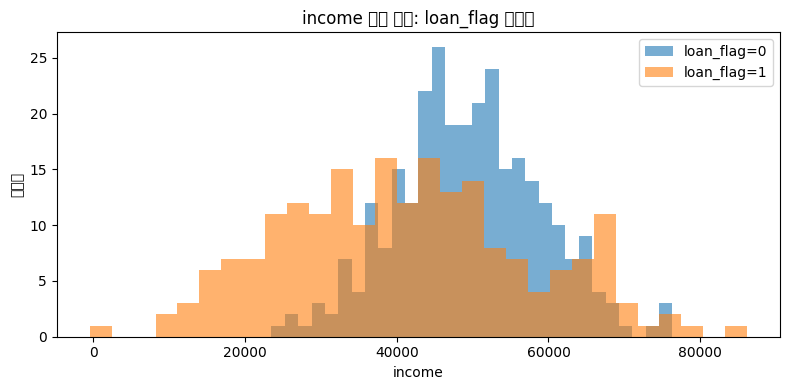

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp, mannwhitneyu
import matplotlib.pyplot as plt

# -----------------------------
# 1. 샘플 데이터 생성
# -----------------------------
np.random.seed(42)

n = 500
df = pd.DataFrame({
    'loan_flag': np.random.choice([0, 1], size=n, p=[0.6, 0.4]),
})

# 대출이 없는 사람은 평균 소득이 높고, 대출 있는 사람은 낮게 설정
df['income'] = df['loan_flag'].apply(lambda x:
                                     np.random.normal(50000, 10000) if x == 0
                                     else np.random.normal(40000, 15000))

# -----------------------------
# 2. KS & Mann–Whitney U 검정 함수 정의
# -----------------------------
def compare_distributions(df, group_col, value_col, group_values=None, plot=True):
    if group_values is None:
        group_values = df[group_col].dropna().unique()[:2]

    group1 = df[df[group_col] == group_values[0]][value_col].dropna()
    group2 = df[df[group_col] == group_values[1]][value_col].dropna()

    ks_stat, ks_p = ks_2samp(group1, group2)
    u_stat, u_p = mannwhitneyu(group1, group2, alternative='two-sided')

    print(f"📊 [Kolmogorov–Smirnov] D={ks_stat:.4f}, p={ks_p:.4f}")
    print(f"📊 [Mann–Whitney U]     U={u_stat:.4f}, p={u_p:.4f}")

    if plot:
        plt.figure(figsize=(8, 4))
        plt.hist(group1, bins=30, alpha=0.6, label=f'{group_col}={group_values[0]}')
        plt.hist(group2, bins=30, alpha=0.6, label=f'{group_col}={group_values[1]}')
        plt.xlabel(value_col)
        plt.ylabel('빈도수')
        plt.title(f'{value_col} 분포 비교: {group_col} 그룹별')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {
        'ks_stat': ks_stat,
        'ks_pvalue': ks_p,
        'u_stat': u_stat,
        'u_pvalue': u_p
    }

# -----------------------------
# 3. 테스트 실행
# -----------------------------
results = compare_distributions(df, group_col='loan_flag', value_col='income')